EOF
Execution time: 491.353 seconds.
Top-1024 in SS[4096]
Precision:  0.891
Total memory usage 147560 bytes
Find:912
Top_ARE: 0.1487
Top_AAE: 72.6173
Estimate time:  0.250 seconds.


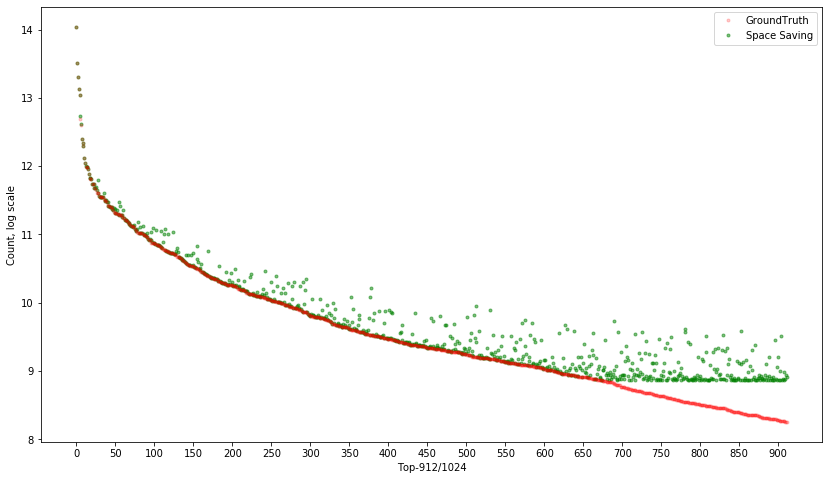

In [1]:
# dictionary version

from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys
import re


# ==========================main========================= 
filepath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path
    
size=4096
    # size of T
topk=1024
    # number of top-k
Config.Set_default(size,topk)
Top_dict=dict()
#item_count=10000

start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            #item_count-=1
            if len(e)<13:
                print('EOF')
                break
            else:  
                item=DS.Tail(e,1)
                #item_count-=1
                # print("read {}th element: {}".format(item_count,element))
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<Config.size:
                        Top_dict[item.ID]=1
                    else:
                        min_ele = min(Top_dict, key=Top_dict.get)
                            # find e_min
                        Top_dict[item.ID]=Top_dict[min_ele]+1
                            # update c_min
                        Top_dict.pop(min_ele)
                            # pop old min out
end=time.time()
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
print("Execution time:{:8.3f} seconds.".format(end-start))


# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
print("Top-{} in SS[{}]".format(Config.topk,Config.size))
print("Precision: {:6.3f}".format(precision))

# memory usage
print("Total memory usage {0} bytes".format(sys.getsizeof(Top_dict)))

# Count ARE/AAE
startx=time.time()
top_are,top_aae=Func.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict)

In [ ]:
import sys
import os
import re
import time
import operator
import pandas as pd

class Node():
    def __init__(self,count=0):
        self.count=count
    def add_count(self,count=1):
        self.count+=count
    def __str__(self):
        return 'ID: {}, count: {}'.format(self.ID,self.count)
    def __repr__(self):
        return ''

class Head(Node):
    def __init__(self):
        super().__init__()
        self.distinct = hyperloglog.HyperLogLog(0.01)
    def __str__(self):
        return 'total count: {}, distinct element: {}'.format(self.count,len(self.distinct))
    def __repr__(self):
        return '[count: {}, distinct: {}]'.format(self.count,len(self.distinct))

class Tail(Node):
    def __init__(self,ID,count):
        self.ID = ID
        super().__init__(count)
    def __str__(self):
        return 'ID: {}, count: {}'.format(self.ID,self.count)
    def __repr__(self):
        return "'{}', count: {}".format(self.ID,self.count)

def find(e,element_list):
    try:
        index = [ele.ID for ele in element_list].index(e.ID)
    except:
        index=-99
    return index  
    
# ==========================main========================= 
datapath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(datapath)))

size=10240
Top=[]
#item_count=100000
'''
filename='caida_0.dat'
filepath="..\\dataset\\"
src_data=os.path.join(filepath,filename)

'''
start=time.time()
for datafile in filelist:
    src_data=os.path.join(datapath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:
                item=Tail(e,1)
                #item_count-=1
                # print("read {}th element: {}".format(item_count,element))
                if len(Top)==0:
                    Top.append(item)
                else:
                    index=find(item,Top)
                    if index<0:
                        # e not in Top
                        index=len(Top)-1
                        if len(Top)<size:
                            Top.append(item)
                        else:
                            # replace last element with count 
                            Top[-1].ID=item.ID
                            Top[-1].count+=1
                    else:
                        Top[index].count+=1
                    if index==0 or Top[index].count< Top[index-1].count:
                        pass
                    else:
                        Top.sort(key=operator.attrgetter('count'),reverse=True) 

end=time.time()
# print(Top[:20],len(Top))
print("Total memory {0} bytes :Top-{1} with size {0} bytes.".format(sys.getsizeof(Top),size))
print("Execution time:{} seconds.".format(str(end-start)))

#====================Top to csv=============================
templi=[[i.ID,i.count] for i in Top]
df=pd.DataFrame(templi,columns=['ID', 'Count'])
df=df.sort_values(by='Count',ascending=False)
name="SS_caida_Top"+'-'+str(size)+'.csv'
df.to_csv(os.path.join(r'..\result',name),index=False)

#====================result compare=============================
gr_path=r"..\dataset\caida"
gr_file_name='caida_0_ground_truth.csv'
grtruth=pd.read_csv(os.path.join(gr_path,gr_file_name))
SS_result=pd.read_csv(os.path.join(r'..\result',name))

# precision
gt_set=set(grtruth['Element'][:size])
    # Top-k of ground truth
my_set=set(SS_result['ID'])
tp_set=gt_set & my_set
precision=len(tp_set)/len(my_set)
    # &: set 交集運算
print("Precision: {:8.4f}".format(precision))

# ====================ARE/AAE for top and all====================
gt_dict=dict(grtruth.values.tolist()[:size])
    # SS只能和Top-k比
my_dict=dict(SS_result.values.tolist())
distinct=len(gt_dict)
top_are=0
top_aae=0
tp=0
fp=0

startx=time.time()
for item in gt_dict:
    # len(gt_dict)=512
    if item in my_dict:
        # ARE/AAE for Top
        top_are+=abs(my_dict[item]-gt_dict[item])/gt_dict[item]
        top_aae+=abs(my_dict[item]-gt_dict[item])
        tp+=1
    else:
        fp+=1
endx=time.time()

ARE=top_are/distinct
AAE=top_aae/distinct
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("ARE: {:8.6f}".format(ARE))
print("AAE: {:8.6f}".format(AAE))


In [ ]:
import sys
import os
import re
import time
import operator
import pandas as pd

class Node():
    def __init__(self,count=0):
        self.count=count
    def add_count(self,count=1):
        self.count+=count
    def __str__(self):
        return 'ID: {}, count: {}'.format(self.ID,self.count)
    def __repr__(self):
        return ''

class Head(Node):
    def __init__(self):
        super().__init__()
        self.distinct = hyperloglog.HyperLogLog(0.01)
    def __str__(self):
        return 'total count: {}, distinct element: {}'.format(self.count,len(self.distinct))
    def __repr__(self):
        return '[count: {}, distinct: {}]'.format(self.count,len(self.distinct))

class Tail(Node):
    def __init__(self,ID,count):
        self.ID = ID
        super().__init__(count)
    def __str__(self):
        return 'ID: {}, count: {}'.format(self.ID,self.count)
    def __repr__(self):
        return "'{}', count: {}".format(self.ID,self.count)

def find(e,element_list):
    try:
        index = [ele.ID for ele in element_list].index(e.ID)
    except:
        index=-99
    return index  
    
# ==========================main========================= 
datapath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(datapath)))

size=512
topk=50
Top_dict=dict()
#item_count=100000
'''
filename='caida_0.dat'
filepath="..\\dataset\\"
src_data=os.path.join(filepath,filename)

'''
start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(datapath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:
                item=Tail(e,1)
                #item_count-=1
                # print("read {}th element: {}".format(item_count,element))                
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<size:
                        Top_dict[item.ID]=1
                    elif len(Top_dict)==size:
                        min_ele = min(Top_dict, key=Top_dict.get)
                        min_count=Top_dict[min_ele]
                        Top_dict.pop(min_ele)
                        Top_dict[item.ID]=min_count+1

end=time.time()
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
# print(Top[:20],len(Top))
print("Total memory {0} bytes :Top-{1} with size {0} bytes.".format(sys.getsizeof(Top_dict),size))
print("Execution time:{} seconds.".format(str(end-start)))

#====================Top to csv=============================
templi=[[i,Top_dict[i]] for i in Top_dict]
df=pd.DataFrame(templi,columns=['ID', 'Count'])
df=df.sort_values(by='Count',ascending=False)
name="SS_caida_Top"+'-'+str(topk)+'.csv'
df.to_csv(os.path.join(r'..\result',name),index=False)

#====================result compare=============================
gr_path=r"..\dataset\caida"
gr_file_name='caida_0_ground_truth.csv'
grtruth=pd.read_csv(os.path.join(gr_path,gr_file_name))
SS_result=pd.read_csv(os.path.join(r'..\result',name))

# precision
gt_set=set(grtruth['Element'][:topk])
    # Top-k of ground truth
my_set=set(SS_result['ID'])
tp_set=gt_set & my_set
precision=len(tp_set)/len(my_set)
    # &: set 交集運算
print("Precision: {:8.4f}".format(precision))

# ====================ARE/AAE for top and all====================
gt_dict=dict(grtruth.values.tolist()[:size])
    # SS只能和Top-k比
my_dict=dict(SS_result.values.tolist())
distinct=len(gt_dict)
top_are=0
top_aae=0
tp=0
fp=0

startx=time.time()
for item in gt_dict:
    # len(gt_dict)=512
    if item in my_dict:
        # ARE/AAE for Top
        top_are+=abs(my_dict[item]-gt_dict[item])/gt_dict[item]
        top_aae+=abs(my_dict[item]-gt_dict[item])
        tp+=1
    else:
        fp+=1
endx=time.time()

ARE=top_are/distinct
AAE=top_aae/distinct
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("ARE: {:8.6f}".format(ARE))
print("AAE: {:8.6f}".format(AAE))
